In [2]:
from shared.preface import *
import shared.functions as fct

## Ch. 0: Preliminary Investigations.

### 2D grid, center coord. pairs.

In [ ]:
def grid_2D(l, s):

    # 2D spatial grid, discretized.
    eps = s/10
    x, y = np.mgrid[-l:l+eps:s, -l:l+eps:s]

    # [x y] edge coordinate pairs of above grid.
    xy = np.mgrid[-l:l+eps:s, -l:l+eps:s].reshape(2,-1).T

    # Create center coord.-pairs.
    x_centers = (x[1:,:] + x[:-1,:])/2.
    y_centers = (y[:,1:] + y[:,:-1])/2.
    centers = np.array([x_centers[:,:-1], y_centers[:-1,:]])
    cent_coordPairs2D = centers.reshape(2,-1).T
    print('All coord. pairs 2D:\n', cent_coordPairs2D)
    # print('Coord pairs 2D shape:', cent_coordPairs2D.shape)

    return cent_coordPairs2D

limit_coarse, space_coarse = 1.5, 1.
cent_coordPairs2D = grid_2D(limit_coarse, space_coarse)

# Delete middle square.
cent_coordPairs2D = np.delete(cent_coordPairs2D, 4, axis=0)

# Create finegrained square.
limit_fine, space_fine = limit_coarse/2., space_coarse/2.
cent_coordPairs2D_fine = grid_2D(limit_fine, space_fine)

# Insert finegrained square.

### 3D grid, center coord. pairs.

In [ ]:
# 3D spatial grid, discretized.
x, y, z = np.mgrid[-1:1.1:1., -1:1.1:1., -1:1.1:1.]
# print(x[0,...], x.shape)

x_centers = (x[1:,...] + x[:-1,...])/2.
# print(x_centers, x_centers.shape)

y_centers = (y[:,1:,:] + y[:,:-1,:])/2.
# print(y_centers, y_centers.shape)

z_centers = (z[...,1:] + z[...,:-1])/2.
# print(z_centers, z_centers.shape)


# Create center coord.-pairs., truncate redundant points.
centers3D = np.array([
    x_centers[:,:-1,:-1], 
    y_centers[:-1,:,:-1], 
    z_centers[:-1,:-1,:]
])
# print(centers3D, centers3D.shape)

cent_coordPairs3D = centers3D.reshape(3,-1).T 
print(cent_coordPairs3D, cent_coordPairs3D.shape)

## Ch. 1: Milky Way-type halo and simple grid.

### 3D plot of the DM particles.

In [ ]:
snap = '0036'
sim_ID = 'L006N188'
m0 = '2.59e+11'
proj = 2

# Generate files with positions of DM particles
fct.read_DM_positions(
    which_halos='halos', mass_select=12,  # unnecessary when giving index...
    random=False, snap_num=snap, sim=sim_ID, 
    halo_index=int(proj), init_m=m0
)

# Build grid around Milky Way.
MW_grid = fct.grid_3D(GRID_L, GRID_S) / kpc

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# Read in DM particle positions.
DM_pos = np.load(
    f'CubeSpace/DM_positions_{sim_ID}_snapshot_{snap}_{m0}Msun.npy'
)

print(f'{len(DM_pos)}')
x_DM, y_DM, z_DM = DM_pos[:,0], DM_pos[:,1], DM_pos[:,2]
cut = 10
x, y, z = x_DM[1::cut], y_DM[1::cut], z_DM[1::cut]

ax.scatter(x, y, z, alpha=0.1, c='dodgerblue')

# Draw sphere around GC with radius=Rvir_MW.
rGC = Rvir_MW/kpc
uGC, vGC = np.mgrid[0:2 * np.pi:200j, 0:np.pi:100j]
xGC = rGC * np.cos(uGC) * np.sin(vGC)
yGC = rGC * np.sin(uGC) * np.sin(vGC)
zGC = rGC * np.cos(vGC)

xg, yg, zg = MW_grid[:,0], MW_grid[:,1], MW_grid[:,2] 
ax.scatter(xg, yg, zg, s=0.2, marker='x', color='black', alpha=0.5)


ax.plot_surface(
    xGC, yGC, zGC, alpha=0.1, 
    cmap=plt.cm.coolwarm, vmin=-1, vmax=1,# antialiased=False,
    rstride=1, cstride=1
)

plt.show()

### Calculate gravity in each cell.

In [ ]:
def cell_gravity(cell_coords, DM_coords, grav_range, m_DM):
    
    # Center all DM positions w.r.t. cell center.
    DM_cc = DM_coords*kpc - cell_coords

    # Calculate distances of DM to cc, sorted in ascending order.
    DM_dist = np.sqrt(np.sum(DM_cc**2, axis=1))

    # Ascending order indices.
    ind = DM_dist.argsort()

    # Truncate DM positions depending on distance to cc.
    DM_pos_sort = DM_cc[ind]
    DM_dist_sort = DM_dist[ind]

    #note: there is a particle exactly at (0,0,0), which causes infinities...
    #? for now manually remove it and discuss with Camila...
    DM_pos_sort = DM_pos_sort[1:]
    DM_dist_sort = DM_dist_sort[1:]

    if grav_range is None:
        DM_pos_inRange = DM_pos_sort
        DM_dist_inRange = DM_dist_sort
    else:
        DM_pos_inRange = DM_pos_sort[DM_dist_sort <= grav_range]
        DM_dist_inRange = DM_dist_sort[DM_dist_sort <= grav_range]

    # Adjust the distances array to make it compatible with DM positions array.
    DM_dist_inRange_sync = DM_dist_inRange.reshape(len(DM_dist_inRange),1)
    DM_dist_inRange_rep = np.repeat(DM_dist_inRange_sync, 3, axis=1)

    ### Calculate superposition gravity.
    pre = G*m_DM
    quotient = (cell_coords-DM_pos_inRange)/(DM_dist_inRange_rep**3)
    derivative = pre*np.sum(quotient, axis=0)

    #NOTE: Minus sign, s.t. velocity changes correctly (see notes).
    return np.asarray(-derivative, dtype=np.float64)


DM_pos = np.load('sim_data/DM_positions_halos_M12.npy')

# For position of Sun/Earth.
cell_coords = np.array([8.5, 0, 0])*kpc
cell_vector = cell_gravity(cell_coords, DM_pos, GRAV_RANGE, DM_SIM_MASS)
cell_vector /= (kpc/s**2)  
print('Position of Sun/Earth:')
print(cell_vector)
print(np.sqrt(np.sum(cell_vector**2)), '\n')

# For position of Sun/Earth.
cell_coords = np.array([0., 0, 0])*kpc
cell_vector = cell_gravity(cell_coords, DM_pos, GRAV_RANGE, DM_SIM_MASS)
cell_vector /= (kpc/s**2)  
print('Position close to center:')
print(cell_vector)
print(np.sqrt(np.sum(cell_vector**2)), '\n')

# For position of Sun/Earth.
cell_coords = np.array([333., 0, 0])*kpc
cell_vector = cell_gravity(cell_coords, DM_pos, GRAV_RANGE, DM_SIM_MASS)
cell_vector /= (kpc/s**2)  
print('Position at virial radius:')
print(cell_vector)
print(np.sqrt(np.sum(cell_vector**2)))

#! values should be around same order of magnitude as in spher. symmetric setup.

## Ch. 2: Broadcasting for cell_gravity.

In [ ]:
snap = '0036'
sim_ID = 'L006N188'
m0 = '2.59e+11'
proj = 2

# Generate files with positions of DM particles
fct.read_DM_positions(
    which_halos='halos', mass_select=12,  # unnecessary when giving index...
    random=False, snap_num=snap, sim=sim_ID, 
    halo_index=int(proj), init_m=m0
)

# Read in DM particle positions.
DM = np.load(
    f'CubeSpace/DM_positions_{sim_ID}_snapshot_{snap}_{m0}Msun.npy'
)

# fct.read_DM_positions(which_halos='halos', mass_select=12, mass_range=1.)
# DM = np.load('sim_data/DM_positions_halos_M12.npy')[1::10]
grid = fct.grid_3D(GRID_L, GRID_S)

grid = np.expand_dims(grid, axis=1)

DM = np.expand_dims(DM, axis=0)
DM = np.repeat(DM, len(grid), axis=0)
print('DM positions array shape', DM.shape)

# diff = DM - grid
# print(diff.shape, (diff.nbytes)/1e6)

fct.cell_gravity_3D(grid, DM, GRAV_RANGE, DM_SIM_MASS, snap)
dPsi_grid = np.load(f'CubeSpace/dPsi_grid_snapshot_{snap}.npy')
dPsi_grid /= (kpc/s**2) 
mags = np.sqrt(np.sum(dPsi_grid**2, axis=1))
print(mags[0])

## Ch. 3: Combined precalculations for all snapshots.

In [ ]:
from shared.preface import *
import shared.functions as fct

for i in range(12,37):
    snap_i = f'{i:04d}'
    print(snap_i)

    # 1. Read in DM positions of halo in snapshot.
    fct.read_DM_positions(
        which_halos='halos', mass_select=12, mass_range=1., snap_num=snap_i
        )
    DM_pos = np.load('sim_data/DM_positions_halos_M12.npy')[1::10]

    # 2. Build the spatial grid, depending on virial radius of halo, etc.
    cell_grid = fct.grid_3D(GRID_L, GRID_S)
    np.save(f'CubeSpace/cell_grid_snapsnot_{snap_i}', cell_grid)
    cell_grid = np.expand_dims(cell_grid, axis=1)

    # 2.5 Adjust arrays.
    DM_pos = np.expand_dims(DM_pos, axis=0)
    DM_pos = np.repeat(DM_pos, len(cell_grid), axis=0)

    # 3. Calculate derivatives of each cell.
    fct.cell_gravity_3D(
        cell_grid, DM_pos, GRAV_RANGE, DM_SIM_MASS, snap_num=snap_i
        )

snapshot_0012 is at redshift ~3.8.

**BUT** it contains no halo of mass_select=12 anymore.

**TODO:** start at snapshot_0036 (z~1e-16) and **trace same halo** backwards through the
snapshots.

Ugly fix for now: Extended mass_select window to search down to 1e11*Msun halos.
Then just pick random halo, will not be the same in all snapshots.

### Redshift z of each snapshot.

In [ ]:
zeds = np.zeros(25)
nums = []
for j, i in enumerate(range(12,37)):
    snap_i = f'{i:04d}'
    nums.append(snap_i)

    with h5py.File(f'{SIM_DATA}/snapshot_{snap_i}.hdf5') as snap:
        zeds[j] = snap['Cosmology'].attrs['Redshift'][0]

np.save(f'shared/ZEDS_SNAPSHOTS.npy', np.asarray(zeds))
np.save(f'shared/NUMS_SNAPSHOTS.npy', np.asarray(nums))

## Ch. 4: Better derivative grid structure. 

In [3]:
def check_grid(init_cc, DM_pos, parent_GRID_S, DM_lim):
    """
    Determine which cells have DM above threshold and thus need division.
    """

    # -------------- #
    # Preliminaries. #
    # -------------- #

    # Range within DM particles are "part of" the cell:
    # Circumscribed circle.
    # DM_range = parent_GRID_S/np.sqrt(2)
    # Inscribed circle.
    DM_range = parent_GRID_S/2.

    # Center all DM positions w.r.t. center, for all cells.
    DM_cc = DM_pos - init_cc

    # Calculate distances of all DM to center, for all cells.
    DM_dist = np.sqrt(np.sum(DM_cc**2, axis=2))

    # Indices to order other arrays according to DM dist in ascending order.
    ind = DM_dist.argsort(axis=1)

    # Reshape these indices for compatibility.
    ind_3D = np.expand_dims(ind, axis=2)
    ind_3D = np.repeat(ind_3D, 3, axis=2)

    # Sort DM arrays according to DM distance with these indices.
    DM_cc_sort = np.take_along_axis(DM_cc, ind_3D, axis=1)
    DM_dist_sort = np.take_along_axis(DM_dist, ind, axis=1)

    # This array is a bit confusing: It has the shape (X,2) and contains pairs 
    # of indices, where the 1st entry is the cell number and the 2nd the index 
    # of a DM particle inside the given range for that cell. X then counts all 
    # DM particles inside range across all cells.
    DM_IDs = np.argwhere(DM_dist_sort <= DM_range)

    # Find the index unique to each cell, up to which the DM particles should
    # be kept, while the rest is outside range and no longer relevant.
    # Due to the method chosen, the last cell is not included and is attached 
    # seperately with np.vstack(...).
    row = DM_IDs.T[1]
    fw_diff = row[:-1] - row[1:]
    max_DM_rows_no_last_cell = np.argwhere(fw_diff.flatten() >= 0).flatten()
    max_DM_rows = np.vstack((DM_IDs[max_DM_rows_no_last_cell,:], DM_IDs[-1,:]))

    # Replace all entries beyond these indices (for each cell) with nan values.
    for i in range(len(init_cc)):

        if i in DM_IDs.T[0]:
            cell_ID = np.where(max_DM_rows[:,0] == i)[0][0]
            DM_cc_sort[i, max_DM_rows[cell_ID,1]+1:, :] = np.nan

        else:
            DM_cc_sort[i, ...] = np.nan

    # Drop "rows" common to all cells, which contain only nan values. This 
    # "maximum row" is determined by the highest value in the array, which 
    # contains the index of the row for each cell, beyond which the values are 
    # replaced by nan values.
    max_DM_rank = np.max(max_DM_rows[:,1])
    DM_cc_compact = np.delete(DM_cc_sort, np.s_[max_DM_rank+1:], axis=1)

    # Count the number of DM particles in each cell, after all the filtering.
    DM_count = np.count_nonzero(~np.isnan(DM_cc_compact[:,:,0]), axis=1)

    # Drop all cells containing an amount of DM below the given threshold, 
    # from the DM positions array...
    cell_cut_IDs = DM_count <= DM_lim
    DM_cc_minimal = np.delete(DM_cc_compact, cell_cut_IDs, axis=0)
    thresh = np.size(DM_cc_minimal, axis=0)

    return cell_cut_IDs, DM_cc_minimal, thresh


def cell_division_iterative(
    init_cc, DM_pos, parent_GRID_S, DM_lim, stable_cc, sim, snap_num
    ):

    # Initiate counters.
    thresh = 1
    cell_division_count = 0

    while thresh > 0:

        cell_cut_IDs, DM_cc_minimal, thresh = check_grid(
            init_cc, DM_pos, parent_GRID_S, DM_lim
        )

        #! If no cells are in need of division -> return final coords.
        if thresh == 0:

            if cell_division_count > 0:
                # The final iteration is a concatenation of the survival cells 
                # from the previous iteration and the newest sub8 cell coords...
                final_cc = np.concatenate((stable_cc, init_cc), axis=0)
                np.save(
                    f'CubeSpace/adapted_cc_{sim}_snapshot_{snap_num}.npy', 
                    final_cc
                )
                return cell_division_count
            else:
                # ...or the initial grid itself, if it's fine-grained already.
                np.save(
                    f'CubeSpace/adapted_cc_{sim}_snapshot_{snap_num}.npy', 
                    init_cc
                )
                return cell_division_count

        else:

            # ...and the initial cell coordinates grid. This array contains all 
            # cells (i.e. their coords. ), which need to be divided into 8 
            # "child cells", hence the name "parent cells".
            parent_cc = np.delete(init_cc, cell_cut_IDs, axis=0)

            # "Reset" the DM coords, s.t. all DM positions are w.r.t. the 
            # origin of (0,0,0) again. This way we can easily center them on 
            # the new child cells again, as done in later steps below.
            DM_cc_reset = DM_cc_minimal + parent_cc


            # -------------------------------------------------- #
            # Replace each parent cell by the 8 new child cells. #
            # -------------------------------------------------- #

            # Repeat each DM "column" 8 times. This will be the DM position 
            # array in the next iteration.
            DM_raw8 = np.repeat(DM_cc_reset, repeats=8, axis=0)

            # Create 8 new cells around origin of (0,0,0). The length and size 
            # of the new cells is determined by the previous length of the 
            # parent cell.
            sub8_GRID_S = parent_GRID_S/2.
            sub8_raw = fct.grid_3D(sub8_GRID_S, sub8_GRID_S)

            # Match dimensions of child-array(s) to parent-array(s).
            sub8 = np.expand_dims(sub8_raw, axis=0)
            sub8 = np.repeat(sub8, len(parent_cc), axis=0)

            # Center child-array(s) on parent cell coords.
            sub8_coords = sub8 - parent_cc

            # Reshape array to match repeated DM position array.
            sub8_coords = np.reshape(sub8_coords, (len(parent_cc)*8, 3))
            sub8_coords = np.expand_dims(sub8_coords, axis=1)

            # Delete all cells in initial cell coords array, corresponding to 
            # the cells in need of division, i.e. the parent cells.
            no_parents_cc = np.delete(init_cc, ~cell_cut_IDs, axis=0)

            if cell_division_count > 0:
                stable_cc_so_far = np.concatenate((stable_cc, no_parents_cc), axis=0)
            else:
                stable_cc_so_far = no_parents_cc

            # Overwrite variables for next loop.
            init_cc       = sub8_coords
            DM_pos        = DM_raw8
            parent_GRID_S = sub8_GRID_S
            stable_cc     = stable_cc_so_far

            cell_division_count += 1


# Values for file reading.
sim_ID = 'L006N188'
snap = '0036'
m0 = '2.59e+11'

# Initial grid and DM positions.
DM_raw = np.load(
    f'CubeSpace/DM_positions_{sim_ID}_snapshot_{snap}_{m0}Msun.npy'
)*kpc
grid = fct.grid_3D(GRID_L, GRID_S)
init_cc = np.expand_dims(grid, axis=1)
DM_pos = np.expand_dims(DM_raw, axis=0)
DM_pos_for_cell_division = np.repeat(DM_pos, len(init_cc), axis=0)

DM_lim = 1000

cell_division_count = cell_division_iterative(
    init_cc, DM_pos_for_cell_division, GRID_S, DM_lim, None,
    sim=sim_ID, snap_num=snap
    )
adapted_cc = np.load(f'CubeSpace/adapted_cc_{sim_ID}_snapshot_{snap}.npy')

print(init_cc.shape)
print(adapted_cc.shape)

print(f'Total cell division rounds: {cell_division_count}')

(343, 1, 3)
(476, 1, 3)
Total cell division rounds: 5


### Plotting the outcome after one iteration.

150358
150323


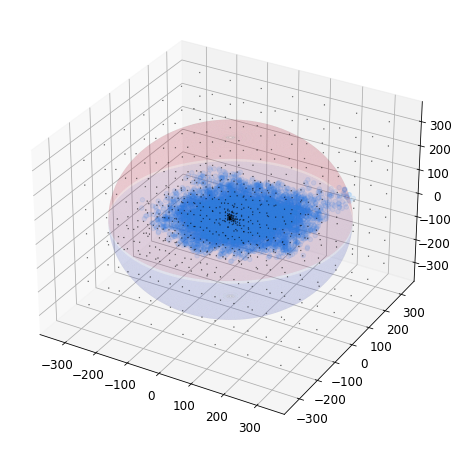

In [6]:
# Build grid around Milky Way.
new_grid = np.squeeze(adapted_cc, axis=1) / kpc

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# Read in DM particle positions.
DM_pos = np.load(
    f'CubeSpace/DM_positions_{sim_ID}_snapshot_{snap}_{m0}Msun.npy'
)
print(f'{len(DM_pos)}')
x_DM, y_DM, z_DM = DM_pos[:,0], DM_pos[:,1], DM_pos[:,2]
cut = 10
x, y, z = x_DM[1::cut], y_DM[1::cut], z_DM[1::cut]

ax.scatter(x, y, z, alpha=0.1, c='dodgerblue')

# Draw sphere around GC with radius=Rvir_MW.
rGC = Rvir_MW/kpc
uGC, vGC = np.mgrid[0:2 * np.pi:200j, 0:np.pi:100j]
xGC = rGC * np.cos(uGC) * np.sin(vGC)
yGC = rGC * np.sin(uGC) * np.sin(vGC)
zGC = rGC * np.cos(vGC)

xg, yg, zg = new_grid[:,0], new_grid[:,1], new_grid[:,2] 
ax.scatter(xg, yg, zg, s=0.2, marker='x', color='black', alpha=0.5)


ax.plot_surface(
    xGC, yGC, zGC, alpha=0.1, 
    cmap=plt.cm.coolwarm, vmin=-1, vmax=1,# antialiased=False,
    rstride=1, cstride=1
)

# How many DM particles inside Virial Radius?
DM_dists = np.sqrt(np.sum(DM_pos**2, axis=1))
inside_VR = DM_pos[DM_dists <= rGC]
print(len(inside_VR))

plt.show()

## Ch. 5: Tracing halo masses through snapshots.

In [ ]:
from shared.preface import *
import shared.functions as fct

import velociraptor
from shared.snapshot_data import snapshot_info
from shared.tree_dataset import TreeCatalogue
from shared.argumentparser import ArgumentParser
from shared import simulation_data

# Ultimate goal: list of indices, one index representing a halo in a snapshot. 
# Together they trace the "same" halo through snapshots.

def look_for_progenitor_index(progenitor_offset, num_progenitors, progenitors_ID, ID, m200c):

    num_haloes = len(num_progenitors)
    pro_indx = np.ones(num_haloes) * (-1)

    for i in range(num_haloes):

        if num_progenitors[i] == 0:
            continue

        num = num_progenitors[i]
        progenitor_list = np.arange(num) + progenitor_offset[i]
        proID = progenitors_ID[progenitor_list]

        _, indx_ID, _ = np.intersect1d(ID, proID, assume_unique=True, return_indices=True, )

        if len(indx_ID) == 0:
            continue

        largest_mass_progenitor = np.argmax(m200c[indx_ID])
        pro_indx[i] = indx_ID[largest_mass_progenitor]

    return pro_indx

def build_tree(sim_info, halo_index, output_file):

    # This function builds the merger tree of your halo selection and stores it in a file

    # You starting snapshot is probably 36 (z=0)
    initial_snap = sim_info.initial_snap
    final_snap = 10

    # How many haloes are we tracking?
    num_haloes = len(halo_index)

    # Let's collect some data from the halo that we are following,
    progenitor_index = np.zeros((num_haloes,initial_snap - final_snap))
    progenitor_index[:, 0] = halo_index
    z = np.zeros(initial_snap - final_snap)

    # Related to mass assembly history
    mass = np.zeros((num_haloes,initial_snap - final_snap))
    type = np.zeros((num_haloes,initial_snap - final_snap))

    catalogue_file = f"{sim_info.directory}/{sim_info.catalogue_base_name}" + "_%04i.properties" % initial_snap
    catalogue = velociraptor.load(catalogue_file)
    m200c = catalogue.masses.mass_200crit.to("Msun").value
    z[0] = catalogue.z
    mass[:, 0] = m200c[halo_index]
    type[:, 0] = catalogue.structure_type.structuretype[halo_index]

    tree_file = f"{sim_info.directory}/merger_tree/MergerTree.snapshot_0%i.VELOCIraptor.tree" % initial_snap
    tree_data = TreeCatalogue(tree_file)

    halo_offset = tree_data.catalogue.ProgenOffsets.value[halo_index]
    num_progenitors = tree_data.catalogue.NumProgen.value[halo_index]
    progenitors_ID = tree_data.catalogue.Progenitors.value

    for snap in range(initial_snap-1,final_snap,-1):

        i = initial_snap - snap
        snapshot_data = snapshot_info(sim_info, snap)
        path_to_catalogue_file = f"{snapshot_data.directory}/{snapshot_data.catalogue_name}"
        catalogue = velociraptor.load(path_to_catalogue_file)
        m200c = catalogue.masses.mass_200crit.to("Msun").value
        z[i] = catalogue.z

        tree_file = f"{sim_info.directory}/merger_tree/MergerTree.snapshot_0%i.VELOCIraptor.tree" % snap
        tree_data = TreeCatalogue(tree_file)

        pro_indx = look_for_progenitor_index(
            halo_offset,
            num_progenitors,
            progenitors_ID,
            tree_data.catalogue.ID.value,
            m200c,
        )

        halo_offset = tree_data.catalogue.ProgenOffsets.value[pro_indx.astype('int')]
        num_progenitors = tree_data.catalogue.NumProgen.value[pro_indx.astype('int')]
        progenitors_ID = tree_data.catalogue.Progenitors.value

        progenitor_index[:, i] = pro_indx
        mass[:, i] = m200c[pro_indx.astype('int')]
        type[:, i] = catalogue.structure_type.structuretype[pro_indx.astype('int')]

    # Write data to file
    data_file = h5py.File(output_file, 'w')
    f = data_file.create_group('Assembly_history')
    f.create_dataset('ID', data=halo_index)
    f.create_dataset('Mass', data=mass)
    f.create_dataset('Redshift', data=z)
    f.create_dataset('Structure_Type', data=type)
    f.create_dataset('Progenitor_index', data=progenitor_index)
    data_file.close()

    return progenitor_index


def make_tree_data(sim_info):

    # Some selection example:
    select_sub_sample = np.where(
        (sim_info.halo_data.log10_halo_mass >= 10) &
        (sim_info.halo_data.log10_halo_mass < 12.5))[0]

    select_type = np.where(sim_info.halo_data.structure_type[select_sub_sample] == 10)[0]

    sample = select_sub_sample[select_type]
    halo_index = sim_info.halo_data.halo_index[sample]

    # Output data
    output_file = f"{sim_info.output_path}/Tree_data_Centrals_" + sim_info.simulation_name + "_93_97.hdf5"
    progenitor_index = build_tree(sim_info, halo_index, output_file)


def main(config: ArgumentParser):

    # Loop over simulation list
    for sim in range(config.number_of_inputs):

        # Fetch relevant input parameters from lists
        directory = config.directory_list
        snapshot = config.snapshot_list[sim]
        catalogue = config.catalogue_list[sim]
        sim_name = config.name_list
        output = config.output_directory

        # Load all data and save it in SimInfo class
        sim_info = simulation_data.SimInfo(
            directory=directory,
            snapshot=snapshot,
            catalogue=catalogue,
            name=sim_name,
            output=output,
            simtype='DMONLY'
        )

        make_tree_data(sim_info)


class Mock_ArgumentParser:
    snapshot_list = [
        'snapshot_0036.hdf5', 
        # 'snapshot_0035.hdf5', 
        # 'snapshot_0034.hdf5'
    ]
    catalogue_list = [
        'subhalo_0036.properties', 
        # 'subhalo_0035.properties', 
        # 'subhalo_0034.properties'
    ]
    directory_list = '/home/fabian/ownCloud/snellius/L006N188'
    name_list = 'MergerTree_test'
    output_directory = '/home/fabian/ownCloud/snellius/MergerTree'
    number_of_inputs = len(snapshot_list)

config_parameters = Mock_ArgumentParser()
main(config_parameters)

In [ ]:
tree_path = '/home/fabian/ownCloud/snellius/MergerTree/Tree_data_Centrals_MergerTree_test_93_97.hdf5'

with h5py.File(tree_path) as tree:
    print(tree.keys())
    Masses = tree['Assembly_history/Mass'][2::5]
    print(Masses.shape)
    print(type(Masses))
    zeds = tree['Assembly_history/Redshift']
    print(zeds.shape)
    
    y = np.asarray(Masses)
    x = np.asarray(zeds)


    fig = plt.figure(figsize=(8,8))

    for m in y:
        plt.semilogy(x, m, label=f'{m[0]:.2e}')

    plt.title(u'Starting mass in labels ->')
    plt.xlabel('redshift')
    plt.ylabel('halo masses [Msun]')
    plt.legend()
    plt.show()